<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-lightning/02-transfer-learning/01_cancer_tissue_detection_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cancer Tissue Detection using Transfer Learning

Transfer learning is a technique that helps us to make use of knowledge acquired from
a previously built model that was designed for a similar task to ours.

In the machine learning community, there are various pre-built models whose weights are
shared by their authors. By re-using those trained model weights, you can avoid longer
training durations and save on computing costs.


In this notebook, we will start with the creation of a simple image classification model
using ResNet-50 architecture on the PCam dataset, which contains image scans of cancer
tissues. 

Later, we will build a text classification model that uses Bi-directional Encoder
Representations from Transformers (BERT).

In both examples, we will make use of a pre-trained model and its weights
and fine-tune the model to make it work for our dataset. 

One great advantage of
a pre-trained model is that since it has already been trained on a vast dataset, we can
get good results in a smaller number of epochs.

Any model that uses transfer learning typically follows this structure:

1. Access the pre-trained model.
2. Configure the pre-trained model.
3. Build the model.
4. Train the model.
5. Evaluate the model's performance.

##Setup

In [ ]:
!pip -q install pytorch-lightning --quiet

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
from torchvision.models import resnet50

import pytorch_lightning as pl

In [3]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.12.1+cu113
pytorch ligthening version: 1.7.7


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/c/histopathologic-cancer-detection
kaggle competitions download -c histopathologic-cancer-detection

unzip -qq histopathologic-cancer-detection.zip
rm -rf histopathologic-cancer-detection.zip

##Dataset

Let's read the dataset and see the head of the dataframe in pandas.

In [7]:
cancer_labels = pd.read_csv("train_labels.csv")
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
cancer_labels["label"].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There are 130908 normal cases (0) and and 89117 abnormal (cancerous) cases (1)

So, it is not highly unbalanced.

In [9]:
print(f"No. of images in training dataset: {len(os.listdir('train'))}")
print(f"No. of images in testing dataset: {len(os.listdir('test'))}")

No. of images in training dataset: 220025
No. of images in testing dataset: 57458


This is a huge dataset, which requires a lot of compute time and resources so for the purpose of learning our first basic image classification model.

We will downsample it to 5000 images and then split it into training and testing dataset.

In [10]:
np.random.seed(0)

train_imgs_orig = os.listdir("train")

selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
print(len(selected_image_list))
print(selected_image_list[0])

10000
37f805317f844dc06b8d423468cfb59ae9011c94.tif


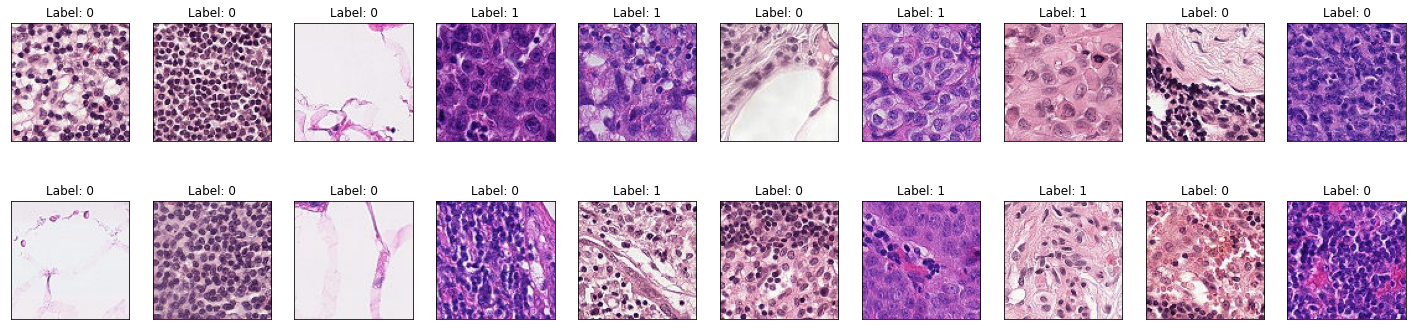

In [11]:
# let's plot some images.
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
  ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
  im = Image.open("train/" + img)
  plt.imshow(im)
  label = cancer_labels.loc[cancer_labels["id"] == img.split(".")[0], "label"].values[0]
  ax.set_title(f"Label: {label}")

In [12]:
# let's split the data into train and test data
np.random.seed(0)

np.random.shuffle(selected_image_list)

cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print(f"Number of images in the downsampled training dataset: {len(cancer_train_idx)}")
print(f"Number of images in the downsampled testing dataset: {len(cancer_test_idx)}")

In [13]:
os.mkdir('train_dataset/')
for fname in cancer_train_idx:
  src = os.path.join('train', fname)
  dst = os.path.join('train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("train_dataset/")))

Number of images in the downsampled training dataset: 8000
Number of images in the downsampled testing dataset: 2000
No. of images in downsampled training dataset:  7847


In [14]:
os.mkdir('test_dataset/')
for fname in cancer_test_idx:
  src = os.path.join('train', fname)
  dst = os.path.join('test_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled testing dataset: ', len(os.listdir("test_dataset/")))

No. of images in downsampled testing dataset:  1989


###Preprocessing the dataset

In [15]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels["id"] == img.split(".")[0]]
  id_list.append(label_tuple["id"].values[0])
  label_list.append(label_tuple["label"].values[0])

selected_image_labels["id"] = id_list
selected_image_labels["label"] = label_list
selected_image_labels.head()

,id,label
0,e51d909b53ecfc95a633f31e9a2988004a8650b7,1
1,d35b049d4d95d47edf457733fcda1cce038f490e,0
2,9981174f92d2cdc06e21ec91fab52bc8a672127a,0
3,76148184c34f99c871871391639ac60d1f34f6b9,1
4,f6c3170c2f45549c6298df34e71ad6b074231410,1


In [16]:
# dictionary with labels and ids of train data
img_label_dict = {k: v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

###Preparing the dataset

The data preparation process will itself consist of multiple steps, as follows:

* Loading the dataset
* Augmenting the dataset

Pytorch lightning expects data to be in folders with the classes. We cannot use the DataLoader module directly when all train images are in one folder without subfolders. 

So, we will write our custom function to carry out the loading.

In [17]:
class CancerDataset(Dataset):
  def __init__(self, data_folder, transform=T.Compose([T.CenterCrop(32), T.ToTensor()]), dict_labels={}):
    self.data_folder = data_folder
    self.list_image_files = [s for s in os.listdir(data_folder)]
    self.transform = transform
    self.dict_labels = dict_labels
    self.labels = [dict_labels[i.split(".")[0]] for i in self.list_image_files]

  def __len__(self):
    return len(self.list_image_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.data_folder, self.list_image_files[idx])
    image = Image.open(img_name)
    image = self.transform(image)
    img_name_short = self.list_image_files[idx].split(".")[0]

    label = self.dict_labels[img_name_short]
    return image, label

Now, we will start the data preprocessing by
augmenting the images.

In [24]:
train_data_transformer = T.Compose([
  T.Resize(224), 
  T.RandomHorizontalFlip(),
  T.ToTensor()
])

test_data_transformer = T.Compose([
  T.Resize(224), 
  T.ToTensor()
])

Now, we will call our `CancerDataset` custom class with the path to the data
folder, transformer, and the image label dictionary.

In [25]:
%%time

# Load train data
training_set = CancerDataset(data_folder="train_dataset/", transform=train_data_transformer, dict_labels=img_label_dict)

CPU times: user 6.89 ms, sys: 5.04 ms, total: 11.9 ms
Wall time: 11.6 ms


In [26]:
%%time

# Load test data
testing_set = CancerDataset(data_folder="test_dataset/", transform=train_data_transformer, dict_labels=img_label_dict)

CPU times: user 3.78 ms, sys: 28 µs, total: 3.81 ms
Wall time: 3.67 ms


In [27]:
# let's create dataloader
batch_size = 128

train_dataloader = DataLoader(training_set, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(testing_set, num_workers=2, pin_memory=True)

##Building the model

The ResNet-50 model is trained on a different dataset. To make the model work on the
PCam dataset, we need to make some configurations and adjustments to the ResNet-50
model, which is done in the model initialization method.

While doing transfer learning, it is important to freeze the weights for the existing layers
to avoid backpropagation and re-training since we are going to leverage the existing
trained model.

In [22]:
class ImageClassifier(pl.LightningModule):

  def __init__(self, learning_rate=0.001):
    super().__init__()

    self.learning_rate = learning_rate 
    self.loss = nn.CrossEntropyLoss()

    # let's load the pretrained model
    self.pretrain_model = resnet50(pretrained=True)
    # set the evaluation mode so that the dropout and batch normalization layers go to evaluation mode
    self.pretrain_model.eval()

    # let's freeze the weights
    for param in self.pretrain_model.parameters():
      param.requires_grad = False

    # let's change the final layer of the ResNet-50 model so that we can classify the two categories
    self.pretrain_model.fc = nn.Linear(2048, 2)

  def forward(self, x):
    # let's pass the data to the pre-trained model
    output = self.pretrain_model(x)
    return output

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr=self.learning_rate)
    return optimizer

  def training_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self(inputs)
    # get the indices of the maximum value of all elements in the input tensor
    preds = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy(preds, targets)
    loss = self.loss(outputs, targets)

    self.log("train_accuracy", train_accuracy, prog_bar=True)
    self.log("train_loss", loss)
    return {"loss": loss, "train_accuracy": train_accuracy}

  def test_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self.forward(inputs)
    preds = torch.argmax(outputs, dim=1)
    test_accuracy = accuracy(preds, targets)
    loss = self.loss(outputs, targets)
    #self.log("test_accuracy", test_accuracy)
    return {"loss": loss, "test_accuracy": test_accuracy}

  # calculate the overall accuracy of the entire dataset
  def test_epoch_end(self, outputs):
    test_outs = []
    for test_out in outputs:
      out = test_out["test_accuracy"]
      test_outs.append(out)
    total_test_accuracy = torch.stack(test_outs).mean()
    self.log("total_test_accuracy", total_test_accuracy, on_step=False, on_epoch=True)
    return total_test_accuracy

##Training the model

In PyTorch Lightning, to train the model, we do the followings:

1. first initialize the trainer class
2. then invoke the fit method to actually train the model

In [ ]:
model = ImageClassifier()

# let's check that model is ready to train
trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model, train_dataloaders=train_dataloader)

In [ ]:
# finally, let's train the model
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)
model = ImageClassifier()

trainer = pl.Trainer(default_root_dir="cnn", gpus=-1, log_every_n_steps=30, max_epochs=10, callbacks=[ckpt_callback])
trainer.fit(model, train_dataloaders=train_dataloader)

##Evaluating the model

In [ ]:
# let's pass test data loader to model and check the accuracy on the test dataset
trainer.test(dataloaders=test_dataloader)

Here, our model is being trained for 10 epochs and achieves an accuracy score of `85%` on
approximately 2,000 test images.

Even with just 10 epochs, we could achieve much better results, since transfer learning
uses image representations learned from ImageNet. 

Without those representations, many
more epochs and hyperparameter tuning would have been required to attain the accuracy
score we did.

##Testing model prediction

In [35]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
  target = target.cuda()
  output = model(data)

  pr = output[:,1].detach().cpu().numpy()
  for i in pr:
      preds.append(i)

In [37]:
test_preds = pd.DataFrame({'imgs': testing_set.list_image_files, 'labels': testing_set.labels,  'preds': preds})
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.head()

,imgs,labels,preds,predictions
0,8f2bff128f7c8c796780ce4cb22e9bd0c75cc74d,0,-15.448347,0
1,1f29c0261035e3ccafd78d96b83a9f1fbc4d6e63,0,0.789506,1
2,884d68dcf0a625941930ee9a018919468553bee4,0,1.155993,1
3,8e2f16b06dbc3887660456778950e5472cdb2773,0,-4.126285,0
4,89cf63662c4d52b997ce79fbbc63fecbb13305a9,1,2.081980,1


In [38]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.5982905982905983